# Debugging `percolate`

## 1. Dealing with the random empty clusters

Some structures percolate at a given temperature $T_1$ but not at another temperature $T_2 > T_1$. This is clearly an erroneous result because if a spanning cluster forms at $T_1$, it must also be realisable at $T_2 > T_1$.

In [1]:
%matplotlib widget

from os import path
import pickle
import numpy as np
from numba import njit
from qcnico.plt_utils import histogram


def get_dcrits(run_inds,temps,datadir):
    nsamples = len(run_inds)
    ntemps = len(temps)
    dcrits = np.zeros((nsamples,ntemps))
    for k in range(nsamples):
        for l in range(ntemps):
            sampdir = f"sample-{run_inds[k]}"
            pkl = f"out_percolate-{temps[l]}K.pkl"
            fo = open(path.join(datadir,sampdir,pkl),'rb')
            dat = pickle.load(fo)
            dcrits[k,l] = dat[1]
            fo.close()

    return dcrits

datadir=path.expanduser("~/Desktop/simulation_outputs/percolation/40x40/percolate_output")
fgood_runs = path.join(datadir, 'good_runs.txt')
with open(fgood_runs) as fo:
    lines = fo.readlines()

# 'Good run' indices
gr_inds = np.array(list(map(int,[line.rstrip().lstrip() for line in lines])))

# temps = np.arange(0,1050,50)
# temps[0] = 10
temps = np.arange(40,440,10)

dcrits = get_dcrits(gr_inds,temps, datadir)
print(dcrits.shape)

davg_T = np.mean(dcrits,axis=0)
dstd_T = np.std(dcrits,axis=0)
print(davg_T.shape)


(174, 40)
(40,)


Check which structures have increasing critical distances with increasing $T$.

In [2]:
ddiffs = np.diff(dcrits)
print("All critical distances decrease with temperature: ", np.all(ddiffs<=0))

All critical distances decrease with temperature:  True


Ok, so for all structures at all $T$: 
$$\frac{\partial d_c}{\partial T} \le 0\,.$$
Good.

Now let's examine the instances where no percolating cluster is found.

In [3]:
def get_clusters_sizes(run_inds,temps,datadir):
    nsamples = len(run_inds)
    ntemps = len(temps)
    sizes = np.zeros((nsamples,ntemps),dtype=int)
    for k in range(nsamples):
        for l in range(ntemps):
            sampdir = "sample-" + str(run_inds[k]) #fstrings don't work in Numba
            pkl = "out_percolate-" + str(temps[l]) + "K.pkl"
            with open(path.join(datadir,sampdir,pkl),'rb') as fo:
                dat = pickle.load(fo)
                c = dat[0]
            if len(c) > 0:
                sizes[k,l] = len(c[0]) #there is only one cluster each time
            else:
                sizes[k,l] = 0
    return sizes

csizes = get_clusters_sizes(gr_inds,temps,datadir)
zero_cluster_inds = (csizes == 0).nonzero()
print("Sample nb. and temperatures where no percolation occured:")
print(np.vstack((gr_inds[zero_cluster_inds[0]], temps[zero_cluster_inds[1]])).T)

Sample nb. and temperatures where no percolation occured:
[[ 25 150]
 [104  80]
 [123  40]
 [161 130]
 [188  80]
 [239  70]]


Let's check out sample 25 and what happens around $T =150\,\text{K}$.

In [4]:
from qcnico.coords_io import read_xsf

def get_cluster_data(run_ind,nMOs,temps,datadir):
    ntemps = len(temps)
    clusters = []
    adjmats = np.zeros((ntemps,nMOs,nMOs),dtype=bool)
    for l in range(ntemps):
        sampdir = "sample-" + str(run_ind) #fstrings don't work in Numba
        pkl = "out_percolate-" + str(temps[l]) + "K.pkl"
        with open(path.join(datadir,sampdir,pkl),'rb') as fo:
            dat = pickle.load(fo)
            clusters.append(dat[0])
            adjmats[l,:,:] = dat[2]
    return clusters, adjmats

def get_npy_data(nn,datadir):
    posdir = path.join(path.dirname(datadir), 'structures')
    Mdir = path.join(path.dirname(datadir), 'MOs_ARPACK')
    edir = path.join(path.dirname(datadir), 'eARPACK')

    posfile = path.join(posdir,f'bigMAC-{nn}_relaxed.xsf')
    Mfile = path.join(Mdir,f'MOs_ARPACK_bigMAC-{nn}.npy')
    efile = path.join(edir, f'eARPACK_bigMAC-{nn}.npy')
    locfile = path.join(datadir,f'sample-{nn}','cc.npy')
    eefile = path.join(datadir,f'sample-{nn}','ee.npy')
    indfile = path.join(datadir,f'sample-{nn}','ii.npy')
    gamLfile = path.join(datadir,f'sample-{nn}',f'gamL_40x40-{nn}.npy')
    gamRfile = path.join(datadir,f'sample-{nn}',f'gamR_40x40-{nn}.npy')

    pos, _ = read_xsf(posfile)
    M = np.load(Mfile)
    energies = np.load(efile) #energies appear only once (apart from degeneracies)
    loc_centers = np.load(locfile)
    ee = np.load(eefile) #each energy appears as many times as its associated has localisation centres
    ii = np.load(indfile)
    gamL = np.load(gamLfile)
    gamR = np.load(gamRfile)

    return pos, M, energies, loc_centers, ee, ii, gamL, gamR


gr_nn = zero_cluster_inds[0][0]
nn = gr_inds[gr_nn] # should equal 25
print(nn)
Tsample_inds = np.array([0,10,11,12,-1])
Tsample = temps[Tsample_inds]
_, _, _, loc_centers, *_ = get_npy_data(nn,datadir)

clusters, adjmats = get_cluster_data(25,loc_centers.shape[0],temps,datadir)

25


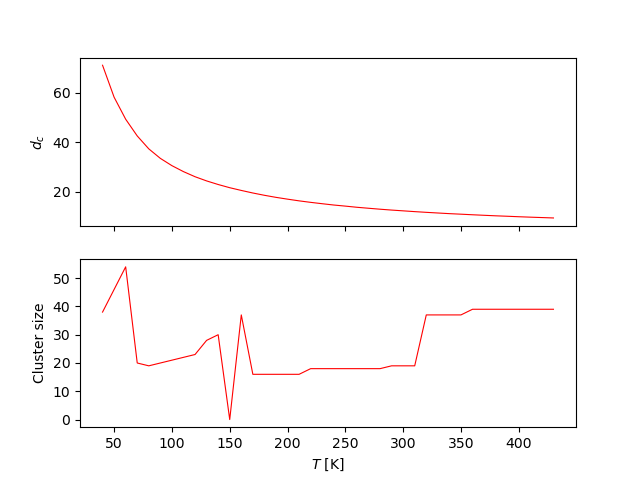

In [5]:
import matplotlib.pyplot as plt

dd25 = dcrits[gr_nn,:]
cs25 = csizes[gr_nn,:]

fig, axs = plt.subplots(2,1,sharex=True)
axs[0].plot(temps,dd25,'r-',lw=0.8)
axs[1].plot(temps,cs25,'r-',lw=0.8)
axs[0].set_ylabel('$d_c$')          
axs[1].set_xlabel('$T$ [K]')
axs[1].set_ylabel('Cluster size')
plt.show()

In [6]:
from percolate import diff_arrs

kB = 8.617e-5
T = 150 #K

edarr, rdarr = diff_arrs(ee,loc_centers,a0=30,eF=0)
MA_dists = (edarr/(kB*T)) +  rdarr
print(np.max(MA_dists))
print(dd25[11])


NameError: name 'ee' is not defined

Figured out the issue; turns out the `percolate` function returned an empty cluster upon reaching the $N^{\text{th}}$ distance, as oppose to the ${N(N-1)/2}^{\text{th}}$ (in increasing order). In other words, it thought it was finished looking at all the inter-centre distances in the structure, when in fact, it still had a bunch more distances to check. 
Issue is fixed now.

Now onto the next issue.

## Clusters with only two overlapping centers

Some clusters are comprised of only two localisation centres whose spatial position overlap. This does not seem correct, as the likelihood of having two MOs coupled to opposite edges coarse-grained to the same localisation centre is quite small. It is possible though, if we have an MO with split localisation on both edges. Let's investigate.

In [7]:
tiny_cluster_inds = (csizes == 2).nonzero()
nn = gr_inds[tiny_cluster_inds[0][0]]
Tsample = temps[tiny_cluster_inds[1]]

pos, M, energies, loc_centers, ee, ii, gamL, gamR  = get_npy_data(nn, datadir)

tiny_clusters, _ = get_cluster_data(nn, ee.shape[0],Tsample,datadir)
tiny_clusters = np.array([list(c) for c in tiny_clusters])
print('All tiny clusters are the same: ', np.all(np.all(tiny_clusters == tiny_clusters[0,:],axis=1)))



All tiny clusters are the same:  True


Only one structure exhibits a 'tiny cluster'. It is the same one at all temperatures where it arises.
Now let's examine the couplings.

In [9]:
tc = np.array(list(tiny_clusters[0][0]))
print('Tiny cluster (loc center inds) = ', tc)
print('Tiny cluster (MO inds) = ', ii[tc])
print('Left couplings of the tiny cluster = ', gamL[ii[tc]])
print('Right couplings of the tiny cluster = ', gamR[ii[tc]])

print('Gamma_L tolerance = ', np.mean(gamL) + 3.0*np.std(gamL))
print('Gamma_R tolerance = ', np.mean(gamR) + 3.0*np.std(gamR))



Tiny cluster (loc center inds) =  [163 142]
Tiny cluster (MO inds) =  [98 87]
Left couplings of the tiny cluster =  [4.24150988e-07 4.07421791e-03]
Right couplings of the tiny cluster =  [0.00815854 0.00041057]
Gamma_L tolerance =  0.0035170867970730495
Gamma_R tolerance =  0.006753148114654465


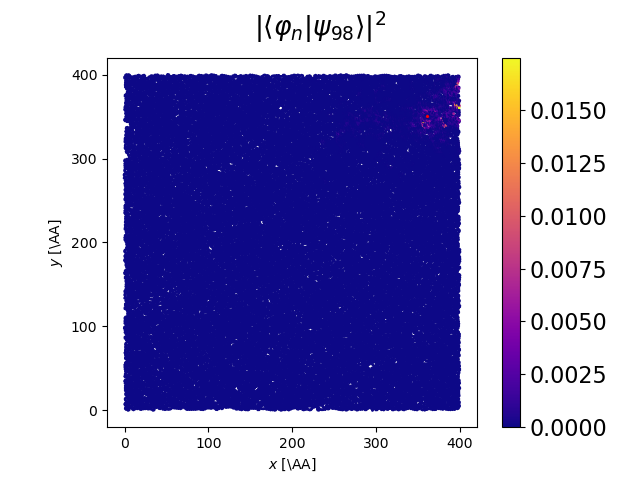

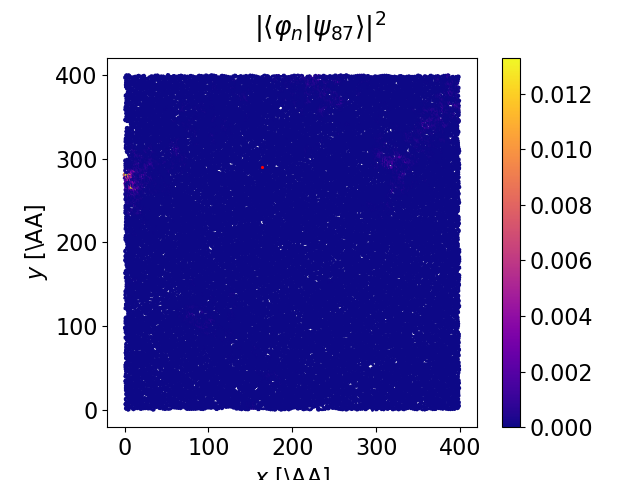

In [10]:
from qcnico.qcplots import plot_MO

for i in ii[tc]:
    fig, ax = plt.subplots()
    plot_MO(pos,M,i,dotsize=1.0,show_COM=True,usetex=False,show=True,plt_objs=(fig,ax))

ARGMAX(rho) =  (19, 20)


TypeError: gridifyMO() missing 1 required positional argument: 'pad_rho'

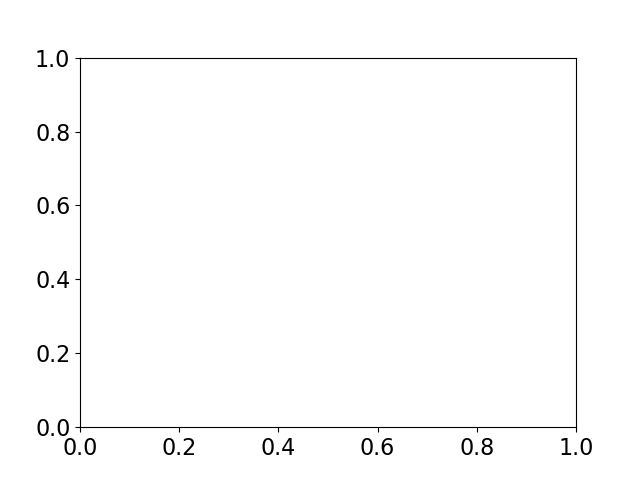

In [17]:
from scipy.signal import find_peaks
from percolate import bin_centers

def gridifyMO(pos,M,n,nbins,pad_rho,return_edges=True):
    x = pos.T[0]
    y = pos.T[1]
    psi = np.abs(M[:,n])**2
    #_, xedges, yedges = np.histogram2d(x,y,nbins)
    xedges = np.linspace(np.min(x)-0.1,np.max(x)+0.1,nbins+1,endpoint=True)
    yedges = np.linspace(np.min(y)-0.1,np.max(y)+0.1,nbins+1,endpoint=True)
    rho = np.zeros((nbins,nbins))
    for c, r in zip(psi,pos):
        x, y, _ = r
        i = np.sum(x > xedges) - 1
        j = np.sum(y > yedges) - 1
        rho[j,i] += c # <----- !!!! caution, 1st index labels y, 2nd labels x
    
    if pad_rho:
        # Pad rho with zeros to detect peaks on the edges (hacky, I know)
        padded_rho = np.zeros((nbins+2,nbins+2))
        padded_rho[1:-1,1:-1] = rho
        rho_out = padded_rho
    else:
        rho_out = rho
    if return_edges:
        return rho_out, xedges, yedges
    else:
        return rho_out

def get_MO_loc_centers_pynb(pos, M, n, nbins=20, threshold_ratio=0.60,return_realspace=True,padded_rho=True):
    rho, xedges, yedges = gridifyMO(pos, M, n, nbins,True)
    if padded_rho:
        dx = np.diff(xedges)[0] #all dxs should be the same since xedges is created using np.linspace
        dy = np.diff(yedges)[0] #idem for dys
        xedges_padded = np.zeros(xedges.shape[0]+2)
        yedges_padded = np.zeros(yedges.shape[0]+2)
        xedges_padded[0] = xedges[0] - dx
        xedges_padded[-1] = xedges[0] + dx
        yedges_padded[0] = yedges[0] - dy
        yedges_padded[-1] = yedges[0] + dy
        xedges_padded[1:-1] = xedges
        yedges_padded[1:-1] = yedges

        xedges_padded = xedges
        yedges_padded = yedges
        nbins = nbins+2



    
    all_peaks = {}
    for i in range(1,nbins-1):
        data = rho[i,:]
        peak_inds, _ = find_peaks(data)
        for j in peak_inds:
            peak_val = data[j]
            if peak_val > 1e-4: all_peaks[(i,j)] = peak_val

    threshold = max(all_peaks.values())*threshold_ratio
    peaks = {key:val for key,val in all_peaks.items() if val >= threshold}
    for ij, pkval in peaks.items():
        print(ij, pkval)

    # Some peaks still occupy several neighbouring pixels; keep only the most prominent pixel
    # so that we have 1 peak <---> 1 pixel.
    pk_inds = set(peaks.keys())
    shift = np.array([[0,1],[1,0],[1,1],[0,-1],[-1,0],[-1,-1],[1,-1],[-1,1]])


    while pk_inds:
        ij = pk_inds.pop()
        print(f"******* {ij} *******")
        nns = set(tuple(nm) for nm in ij + shift)
        intersect = nns & pk_inds
        for nm in intersect:
            if peaks[nm] <= peaks[ij]:
                print(nm, peaks[nm])
                peaks[nm] = 0

    #need to swap indices of peak position; 1st index actually labels y and 2nd labels x
    peak_inds = np.roll([key for key in peaks.keys() if peaks[key] > 0],shift=1,axis=1)
    if return_realspace:
        return bin_centers(peak_inds,xedges,yedges)
    else:
        return peak_inds  

nbins = 20
threshold_ratio = 0.60

for i in ii[tc]:
    fig, ax = plt.subplots()
    rho, xedges, yedges = gridifyMO(pos ,M, i, nbins,True)
    print('ARGMAX(rho) = ', np.unravel_index(np.argmax(rho),shape=rho.shape))
    cc = np.array(get_MO_loc_centers_pynb(pos,M,i,nbins,threshold_ratio,return_realspace=False))
    if cc.shape[0] == 1: cc = cc[0,:]
    print(cc)
    ax.set_title("Coarse grained $\langle\\varphi|\psi_{%d}\\rangle$"%i)
    ax.imshow(rho, origin='lower')#,extent=[*xedges[[0,-1]], *yedges[[0,-1]]])
    ax.scatter(*cc.T,c='r',marker='*',s=5.0)
    plt.show()
    
    


In [ ]:
rho, *_  = gridifyMO(pos,M,ii[tc[0]],nbins)
print(rho[17,18])
print(rho[18,17])


0.1427010623663513
0.011199408118230704


In [ ]:
Xmin = np.inf
Ymin = np.inf
Xmax = -np.inf
Ymax = -np.inf

for i in gr_inds:
    print(i)
    pos, *_ = get_npy_data(i,datadir)
    xmin = np.min(pos[0,:])
    ymin = np.min(pos[1,:])
    xmax = np.max(pos[0,:])
    ymax = np.max(pos[1,:])
    if xmin < Xmin: Xmin = xmin
    if ymin < Ymin: Ymin = ymin
    if xmax > Xmax: Xmax = xmax
    if ymax > Ymax: Ymax = ymax

print(Xmin,Ymin)
print(Xmax,Ymax)

2
5
6
9
13
14
15
16
17
19
21
23
25
27
28
29
30
32
33
34
36
37
38
39
40
41
43
44
45
48
49
50
51
52
54
55
56
57
58
60
69
70
72
73
75
80
81
82
83
84
86
87
88
89
91
92
93
95
96
97
98
99
104
105
106
107
108
109
113
114
115
116
118
119
120
122
123
124
125
126
129
130
131
132
133
134
137
139
143
145
146
148


ValueError: cannot reshape array of size 3796976 into shape (111,57753)